In [10]:
import sys, os, importlib

In [11]:

import json
import subprocess
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU

import tensorflow as tf
# print(tf.__version__)
# if tf.__version__[0] == '1':
#     tf.compat.v1.enable_eager_execution()

tf.compat.v1.enable_eager_execution()
import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
from cooltools.lib.numutils import set_diag

from basenji import dataset, dna_io, seqnn

## Load trained model

In [12]:
### load params, specify model ###

model_dir = './'
params_file = model_dir+'params.json'
model_file  = model_dir+'model_best.h5'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seqnn_model = seqnn.SeqNN(params_model)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1048576, 4)] 0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement_1 ((None, 1048576, 4), 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift_1 (StochasticS (None, 1048576, 4)   0           stochastic_reverse_complement_1[0
__________________________________________________________________________________________________
re_lu_42 (ReLU)                 (None, 1048576, 4)   0           stochastic_shift_1[0][0]         
____________________________________________________________________________________________

In [13]:
seqnn_model.num_targets()

5

In [17]:
### names of targets ###
data_dir =   '/wynton/home/capra/egilbertson/bin/basenji/manuscripts/akita/data/'

hic_targets = pd.read_csv(data_dir+'/targets.txt',sep='\t')
hic_file_dict_num = dict(zip(hic_targets['index'].values, hic_targets['file'].values) )
hic_file_dict    = dict(zip(hic_targets['identifier'].values, hic_targets['file'].values) )
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )

# read data parameters
data_stats_file = '%s/statistics.json' % data_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

## Make predictions for saved tfrecords

In [18]:
### load data ###

# note: run %%bash get_data.sh 
# if you have not already downloaded the data

sequences = pd.read_csv(data_dir+'sequences.bed', sep='\t', names=['chr','start','stop','type'])
sequences_test = sequences.iloc[sequences['type'].values=='test']
sequences_test.reset_index(inplace=True, drop=True)

test_data = dataset.SeqDataset(data_dir, 'test', batch_size=8)

# test_targets is a float array with shape 
# [#regions, #pixels, target #target datasets]
# representing log(obs/exp)data, where #pixels 
# corresponds to the number of entries in the flattened
# upper-triangular representation of the matrix

# test_inputs are 1-hot encoded arrays with shape
# [#regions, 2^20 bp, 4 nucleotides datasets]

test_inputs, test_targets = test_data.numpy(return_inputs=True, return_outputs=True)

In [19]:
### for converting from flattened upper-triangluar vector to symmetric matrix  ###

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

target_length1_cropped = target_length1 - 2*target_crop
print('flattened representation length:', target_length) 
print('symmetrix matrix size:', '('+str(target_length1_cropped)+','+str(target_length1_cropped)+')')

flattened representation length: 99681
symmetrix matrix size: (448,448)


In [20]:
fig2_examples = [   'chr12:115163136-116211712',
                    'chr11:75429888-76478464',
                    'chr15:63281152-64329728' ]
fig2_inds = []
for seq in fig2_examples:
    print(seq)
    chrm,start,stop = seq.split(':')[0], seq.split(':')[1].split('-')[0], seq.split(':')[1].split('-')[1]
    test_ind = np.where( (sequences_test['chr'].values== chrm) *
                         (sequences_test['start'].values== int(start))*
                         (sequences_test['stop'].values==  int(stop ))  )[0][0]
    fig2_inds.append(test_ind)
fig2_inds

chr12:115163136-116211712
chr11:75429888-76478464
chr15:63281152-64329728


[85, 402, 393]

In [23]:
target_length1_cropped

448

In [24]:
hic_diags

2

In [27]:
 test_pred = seqnn_model.model.predict(test_inputs[test_index:test_index+1,:,:])

In [32]:
test_pred[0,:,0]

array([5.7831297, 6.0729465, 6.0921392, ..., 5.543646 , 5.5754385,
       5.440791 ], dtype=float32)

In [26]:
### make predictions and plot the three examples above ###

target_index = 0 # HFF 

for test_index in fig2_inds:
    chrm, seq_start, seq_end = sequences_test.iloc[test_index][0:3]
    myseq_str = chrm+':'+str(seq_start)+'-'+str(seq_end)
    print(' ')
    print(myseq_str)
    
    test_target = test_targets[test_index:test_index+1,:,:]
    test_pred = seqnn_model.model.predict(test_inputs[test_index:test_index+1,:,:])

    plt.figure(figsize=(8,4))
    target_index = 0
    vmin=-2; vmax=2

    # plot pred
    plt.subplot(121) 
    mat = from_upper_triu(test_pred[:,:,target_index], target_length1_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('pred-'+str(hic_num_to_name_dict[target_index]),y=1.15 )
    plt.ylabel(myseq_str)

    # plot target 
    plt.subplot(122) 
    mat = from_upper_triu(test_target[:,:,target_index], target_length1_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( 'target-'+str(hic_num_to_name_dict[target_index]),y=1.15)

    plt.tight_layout()
    plt.show()

 
chr12:115163136-116211712


KeyboardInterrupt: 

## Make a prediction from sequence

In [22]:
### make a prediction from sequence ###

if not os.path.isfile('./data/hg38.ml.fa'):
    print('downloading hg38.ml.fa')
    subprocess.call('curl -o ./data/hg38.ml.fa.gz https://storage.googleapis.com/basenji_barnyard/hg38.ml.fa.gz', shell=True)
    subprocess.call('gunzip ./data/hg38.ml.fa.gz', shell=True)

fasta_open = pysam.Fastafile('./data/hg38.ml.fa')

In [24]:
sequences_test

,chr,start,stop,type
0,chr9,135012352,136060928,test
1,chr1,188526592,189575168,test
2,chr6,115486720,116535296,test
3,chr10,83025920,84074496,test
4,chr6,156624896,157673472,test
...,...,...,...,...
408,chr7,37795840,38844416,test
409,chr19,13506560,14555136,test
410,chr7,21473280,22521856,test
411,chr4,56834048,57882624,test


In [27]:
# this example uses the sequence for the test set region
# with the corresponding test_index, but
# predictions can be made for any DNA sequence of length = seq_length = 2^20

chrm, seq_start, seq_end = sequences_test.iloc[test_index][0:3] 
seq = fasta_open.fetch( chrm, seq_start, seq_end ).upper()
if len(seq) != seq_length: raise ValueError('len(seq) != seq_length')

# seq_1hot is a np.array with shape [2^20 bp, 4 nucleotides]
# representing 1-hot encoded DNA sequence
seq_1hot = dna_io.dna_1hot(seq)

In [9]:
# expand input dimensions, as model accepts arrays of size [#regions,2^20bp, 4]
test_pred_from_seq = seqnn_model.model.predict(np.expand_dims(seq_1hot,0))

NameError: name 'seq_1hot' is not defined

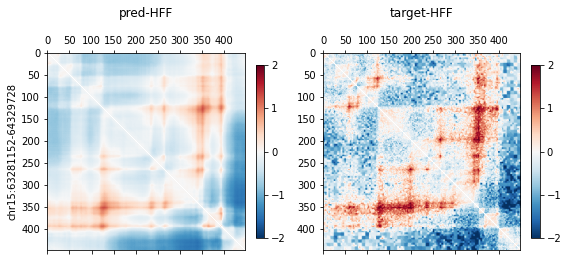

In [32]:
# plot pred

plt.figure(figsize=(8,4))
target_index = 0
vmin=-2; vmax=2

#transform from flattened representation to symmetric matrix representation
mat = from_upper_triu(test_pred_from_seq[:,:,target_index], target_length1_cropped, hic_diags)

plt.subplot(121) 
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
plt.title('pred-'+str(hic_num_to_name_dict[target_index]),y=1.15 )
plt.ylabel(myseq_str)

# plot target 
plt.subplot(122) 
mat = from_upper_triu(test_target[:,:,target_index], target_length1_cropped, hic_diags)
im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
plt.title( 'target-'+str(hic_num_to_name_dict[target_index]),y=1.15)

plt.tight_layout()
plt.show()